# Pandana demo

Sam Maurer, July 2020

This notebook demonstrates the main features of the [Pandana](https://github.com/UDST/pandana/) library, a Python package for network analysis that uses [contraction hierarchies](https://en.wikipedia.org/wiki/Contraction_hierarchies) to calculate super-fast travel accessibility metrics and shortest paths.

See full documentation here: http://udst.github.io/pandana/

### Sections

- [1. Loading data](#section1)
- [2. Shortest paths](#section2)
- [3. Proximity](#section3)
- [4. Accessibility](#section4)
- [5. Visualization](#section5)

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandana
print("pandana version:", pandana.__version__)

pandana version: 0.7


Suppress scientific notation in the output.

In [2]:
pd.options.display.float_format = '{:.2f}'.format

<a id='section1'></a>

## 1. Loading data

### Load street networks directly from Open Street Map

This requires installing a Pandana extension called OSMnet.
- `conda install osmnet` or  `pip install osmnet`

You can use http://boundingbox.klokantech.com/ to get the coordinates of bounding boxes.

In [3]:
# conda install osmnet
# conda install conda-forge::osmnet

In [4]:
from pandana.loaders import osm

import warnings
warnings.filterwarnings('ignore')

- [pandana.loaders.osm.pdna_network_from_bbox()](http://udst.github.io/pandana/loaders.html#openstreetmap-api)

In [5]:
network = osm.pdna_network_from_bbox(37.698, -122.517, 37.819, -122.354)  # San Francisco, CA

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](37.69800000,-122.51700000,37.81900000,-122.35400000);>;);out;'}"
Downloaded 33,158.0KB from www.overpass-api.de in 2.48 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 3.19 seconds
Returning OSM data with 181,801 nodes and 46,555 ways...
Edge node pairs completed. Took 25.59 seconds
Returning processed graph with 58,817 nodes and 86,984 edges...
Completed OSM data download and Pandana node and edge table creation in 30.68 seconds


### What does the network look like?

Edges and nodes are visible as DataFrames.

In [6]:
network.nodes_df.head()

,x,y
id,,
33241803,-122.40,37.81
33242031,-122.42,37.80
54763573,-122.40,37.77
54891208,-122.39,37.77
54891395,-122.39,37.77


In [7]:
network.edges_df.head()

from          to  distance
33241803 65359323    33241803    65359323     10.41
         2071244838  33241803  2071244838     13.97
         9209919063  33241803  9209919063     12.52
33242031 65292112    33242031    65292112     71.49
         65292114    33242031    65292114     75.13

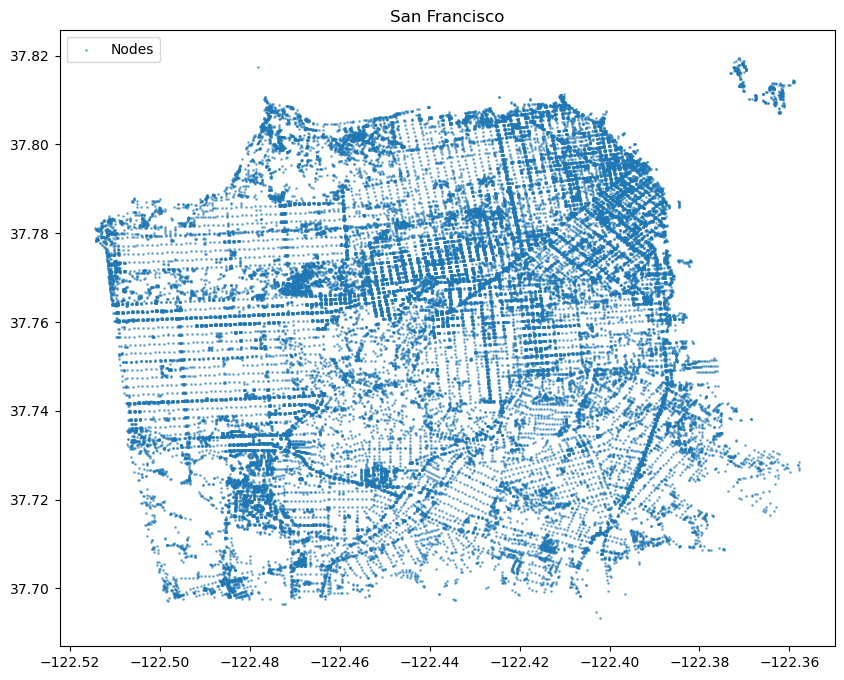

In [17]:
# Visualize the network
fig, ax = plt.subplots(figsize=(10,8))
plt.title("San Francisco")
plt.scatter(network.nodes_df.x, network.nodes_df.y, s=1, alpha=0.5) # reduce point size and alpha(transparency) to make the plot more readable
plt.legend(['Nodes']) # Nodes in the road network
plt.show()

### Saving and reloading networks

You can't directly save a Pandana network object, but you can easily recreate it from the nodes and edges.
- [pandana.Network()](http://udst.github.io/pandana/network.html#pandana.network.Network)

In [18]:
network.nodes_df.to_csv('nodes.csv')
network.edges_df.to_csv('edges.csv')

In [19]:
nodes = pd.read_csv('nodes.csv', index_col=0)
edges = pd.read_csv('edges.csv', index_col=[0,1])

In [21]:
network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])

<a id='section2'></a>

## 2. Shortest paths

This functionality was added in Pandana v0.5.

### Load some restaurant locations

Here we'll load the locations of restaurants listed on Open Street Map (using the same OSMnet extension as above), and then calculate some shortest paths between them.
- [pandana.loaders.osm.node_query()](http://udst.github.io/pandana/loaders.html#pandana.loaders.osm.node_query)

In [41]:
# Load the OpenStreetMap data for restaurants in San Francisco
restaurants = osm.node_query(lat_min=37.698, lng_min=-122.517, lat_max=37.819, lng_max=-122.354, tags='"amenity"="restaurant"')

Choose two at random:

In [23]:
res = restaurants.sample(2)
res

,lat,lon,amenity,cuisine,diet:vegetarian,name,wheelchair,addr:city,addr:country,addr:housenumber,...,contact:tripadvisor,was:contact:facebook,craft,drink:tequila,height,was:phone,diet:keto,diet:fish,diet:seafood,note:website
id,,,,,,,,,,,,,,,,,,,,,
6704512686,37.79,-122.40,restaurant,NaN,NaN,Ladle & Leaf,NaN,NaN,NaN,221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4113404991,37.74,-122.42,restaurant,northern_iranian,NaN,Komaaj,NaN,San Francisco,NaN,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate the shortest route between them

First, identify the nearest node to each restaurant.
- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)

In [46]:
# nodes = network.get_node_ids(res.lon, res.lat).values
# nodes

# Calculate the distance from each restaurant to every other node in the network
restaurant_nodes = network.get_node_ids(x_col=res.lon, y_col=res.lat).values

Then get the routing between the nodes.   
Edge weight (or impedance) can be set to any attribute of the edges, such as distance or travel time.

| Functions                                                          | Description                                                                                   |
|---------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| [shortest_path(node_a, node_b, imp_name=None)](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path)       | Returns an array of the traversed nodes between 2 nodes (origin and destination).             |
| [shortest_path_length(node_a, node_b, imp_name=None)](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path_length) | Return single float-value of the length of the shortest path between two node IDs in the network. (OBS: non-vectorized; don't use for many paths!). |
| [shortest_path_lengths(nodes_a, nodes_b, imp_name=None)](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path_lengths) | Return array of float-values of the length of the shortest path between node IDs in the network. (Vectorized version). |
| [shortest_paths(nodes_a, nodes_b, imp_name=None)](https://udst.github.io/pandana/network.html#pandana.network.Network.shortest_paths)     | Returns an np.ndarray of the nodes traversed between each pair of origin and destination nodes (Vectorized version). |

In [49]:
traversed_nodes = network.shortest_path(restaurant_nodes[0], restaurant_nodes[1]) # traversed nodes in the shortest path between the two restaurants
traversed_nodes

array([ 5020557545,  6639386717,    65305815,  6639386716,  7274605251,
        7233943471,    65303529,  7233943473,  4089809876,  7155175569,
        1419794083,    65305814,  7155175568,  2068535620,  1723738893,
        5858516695,  2068535613,  2068535626,  5015539834,  5005468353,
        7209258483,  7228376761,  5854921103,  1723738952,  6339001622,
        7209258484,  7240842249,  7209260186,  7217057131,  7209260185,
        7209002721,  6338957274,  6338957273,  6338957272,  6339001628,
        7217057140, 11342772560,  9301919019,  6338956525,  7217057143,
        9301919018,  6338956527,  6338957271,  5318198810,  6338957270,
        6338956529,  7217057146,  6338957262,  6338957266,  6338956538,
        6338957275,   763026589,  6338827128,  6338956550,  6338827161,
        6338827135,  6338827154,  4850395378,  6386250950,  6386250946,
        6338827153,  6338827169,  7237422693,  7237422689,  6338827136,
        9581957720,  7237422687,  6338827149,  6338827152,  6338

In [50]:
restaurants_distance = network.shortest_path_length(node_a=restaurant_nodes[0], node_b=restaurant_nodes[1], imp_name=None) # distance in meters between the two restaurants
restaurants_distance

6006.643

This network's distance units are meters.

### Calculate many shortest paths at once

Pandana can generate several million shortest paths in less than a minute.

In [27]:
restaurant_nodes = network.get_node_ids(restaurants.lon, restaurants.lat).values

In [52]:
origs = [o for o in restaurant_nodes for d in restaurant_nodes]
dests = [d for o in restaurant_nodes for d in restaurant_nodes]
origs, dests

([5020557545, 5020557545, 2399952062, 2399952062],
 [5020557545, 2399952062, 5020557545, 2399952062])

In [29]:
%%time
distances = network.shortest_path_lengths(origs, dests) # distance in meters between each pair of restaurants

CPU times: total: 5min 36s
Wall time: 51.8 s


Now we have the distance from each restaurant to each other restaurant.

In [30]:
pd.Series(distances).describe()

count   2920681.00
mean      39816.24
std      386108.15
min           0.00
25%        2579.97
50%        4465.98
75%        6670.22
max     4294967.29
dtype: float64

<a id='section3'></a>

## 3. Proximity

### Find the closest restaurants to each node

To do a network-wide calculation like this, we first need to formally add the restaurants into the network.
- [network.set_pois(category=None, maxdist=None, maxitems=None, x_col=None, y_col=None, mapping_distance=None)](http://udst.github.io/pandana/network.html#pandana.network.Network.set_pois) - 
 Set the location of all the points of interest (POIs) of this category.   
The POIs are connected to the closest node in the Pandana network which assumes no impedance between the location of the variable and the location of the closest network node.

In [31]:
network.set_pois(category = 'restaurants',
                 maxdist = 1000,
                 maxitems = 3,
                 x_col = restaurants.lon, 
                 y_col = restaurants.lat)

(The `maxdist` and `maxitems` parameters are the maximum distance and item counts you anticipate using in proximity searches, so that Pandana can optimize the caching.)

Now we can run the query.
 - [nearest_pois(distance, category, num_pois=1, max_distance=None, imp_name=None, include_poi_ids=False)](http://udst.github.io/pandana/network.html#pandana.network.Network.nearest_pois)   
 Find the distance to the nearest points of interest (POI)s from each source node. The bigger values in this case mean less accessibility.

In [32]:
results = network.nearest_pois(distance = 1000,
                               category = 'restaurants',
                               num_pois = 3,
                               include_poi_ids = True)
results.head()

,1,2,3,poi1,poi2,poi3
id,,,,,,
33241803,335.67,350.77,643.03,4077886989.00,1436065856.00,371250864.00
33242031,273.17,275.24,290.37,3609348594.00,1478520956.00,1478520961.00
54763573,263.05,408.66,415.29,1771741233.00,9477190984.00,6252387628.00
54891208,56.51,226.17,335.91,10806697926.00,2453599646.00,5512661856.00
54891395,266.57,304.14,437.30,2453599646.00,10806697926.00,6146447085.00


These are the distances (in meters) and IDs of the three closest restaurants to each network node.

<a id='section4'></a>

## 4. Accessibility

### How many restaurants are within 500 meters of each node?

Pandana calls this kind of calculation an *aggregation*. It requires passing a list of network nodes and associated values. 

In this case, the "value" is just presence of a restaurant, but it could also be characteristics like square footage of a building or income of a household.

- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)
- [network.set()](http://udst.github.io/pandana/network.html#pandana.network.Network.set_pois)

In [33]:
restaurant_nodes = network.get_node_ids(restaurants.lon, restaurants.lat)

In [34]:
network.set(restaurant_nodes, 
            name = 'restaurants')

Now we can run the query.

- [network.aggregate()](http://udst.github.io/pandana/network.html#pandana.network.Network.aggregate)

In [35]:
accessibility = network.aggregate(distance = 500,
                                  type = 'count',
                                  name = 'restaurants')
accessibility.describe()

count   58817.00
mean       11.43
std        17.57
min         0.00
25%         0.00
50%         4.00
75%        15.00
max       144.00
dtype: float64

Note that you can also calculate means, sums, percentiles, and other metrics, as well as applying linear or exponential "decay" to more distant values.

<a id='section5'></a>

## 5. Visualization

Pandana's built-in `plot` function uses an older Matplotlib extension called Basemap that's now difficult to install. So here we'll just use Matplotlib directly.

### Mapping restaurant accessibility

In [36]:
import matplotlib
from matplotlib import pyplot as plt

print(matplotlib.__version__)

3.8.0


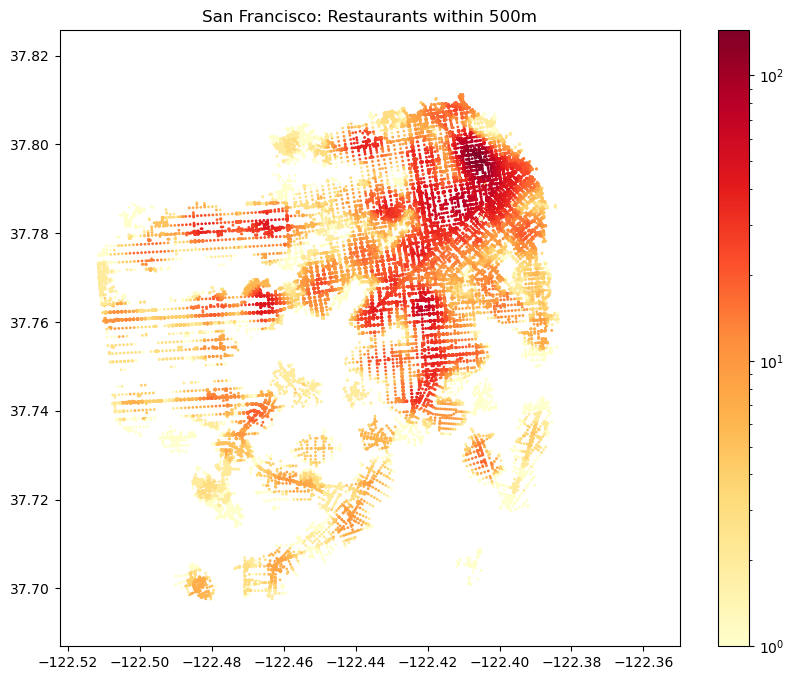

In [37]:
fig, ax = plt.subplots(figsize=(10,8))

plt.title('San Francisco: Restaurants within 500m')
plt.scatter(network.nodes_df.x, network.nodes_df.y, 
            c=accessibility, s=1, cmap='YlOrRd', 
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()
plt.show()